# 前モデルの説明: `CircleModel2`
- サークルグラフを考える。
- 各世代ごとにノードiのリソースが最大となり、ノード mod(i + N/2, N) のリソースが最小となる。
- 各ノードは隣接ノードの一つとゲームを行う。
    - C: 自分のリソースのrを拠出し、プール財をb倍して均等配分。
    - D: 自分はリソースを拠出せず、プール財をb倍して均等配分。
- Death & Birth
    - Param.resource_limit 以下のリソースしか持っていないエージェントは全員死ぬ。
    - 死んだ人数分、親が選ばれる。
    - 各親はそれぞれ一人の子を生む。
    - 子は親とつながる。
    - 総エッジ数 < N * \<k\> ÷ 2の場合は、不足分を子から親以外のノードにつなぐ.

→

リッチスポットが動かない場合は、協力率が安定する。つまり、初期協力率からあまり変動しない。

リッチスポットが動く場合は、協力率が不安定になる。100%を実現することもあれば、0%になることもある。

# 前モデルの説明: `CircleModel3`

一度成立した協力レジームが維持されやすくするにはどうすればよいか？を考える。

協力者同士の繋がりを強くして、協力者と非協力者の繋がりを弱める。

`CircleModel2` に以下の変更を加える。

- ネットワークを重み付きネットワークにする。初期重みw0 = 1.0、重みw: 0 < w <= 1
- Interaction
    - Interactionの相手は隣人の内、重みが大きい相手と起こりやすい
    - CCの場合は1.1倍
    - CD, DC, DD の場合は0.9倍
    - 重みは常に 0 < w <= 1 になるように線形変換。
- Death & Birth
    - 親子の繋がりはw0とする。

# 当モデルの説明: `CircleModel4`

- `p.peak_node_resource::Float64 = 1.0` を追加
- 基本的にリソースリミット未満のエージェントは全員死ぬが。死者数がNの50%以上にはならないようにする。50%を超えた場合は、リソースが低い人を50%選び殺して、それ以外を親とする。→ 恣意的だからやめる。やっぱり、リソースリミットを下回ってたら全員死ぬべき。
- get_death_parent_id_vec にシャッフル処理を追加。
- weighted_interaction! で focal を取り出す順番もシャッフル。
- contributable_resource のロジックが鍵になってくる。
- リソースアロケーション
    - 0 <= r <= 1
    - r_{i+1} = r_i - f_RD if r_{i+1} >= 0 else 0
    - r_L が変動する場合
        - AR(1) 自己回帰係数β、ホワイトノイズの標準偏差σ
- 地理的差異は存在する。
    - 1. ピークノードが変動する。`r_L`は変動しない。
    - 2. ピークノードは変動しない。`r_L`は変動する。
    - 3. ピークノードも`r_L`も変動する。

# Model

In [3]:
using Dates
using StatsBase: mean, std, shuffle, sample, Weights, countmap
using Statistics
using Parameters
using Random: MersenneTwister

using Graphs

using Colors
using Plots
using GraphPlot

using Test: @testset, @test

# Performance Profiling
using Profile
using ProfileView

include("../src/ColorScheme.jl")
using .ColorScheme: DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE, COLOR_GRAD

include("../src/Network.jl")
using .Network: create_weighted_cycle_graph, create_cycle_graph, desc, plot_degree_distribution, mat_nv, mat_ne, mat_degree, mat_update_weight!, plot_graph, average_distance

include("../src/EnvironmentalVariability.jl")
using .EnvironmentalVariability: ar1

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [4]:
# Color scheme
[DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE] |> display
COLOR_GRAD |> display

## Network

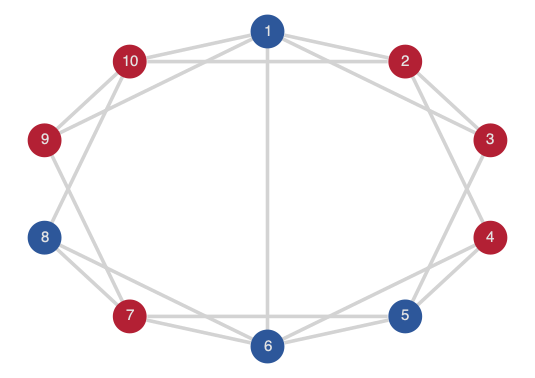

Test Summary:               | Pass  Total  Time
create_weighted_cycle_graph |    9      9  3.4s
Average Degree (k̄):	 3.8
Average Distance (L):	 1.6666666666666667
Average Clustering Coefficient (C):	 0.32142857142857145


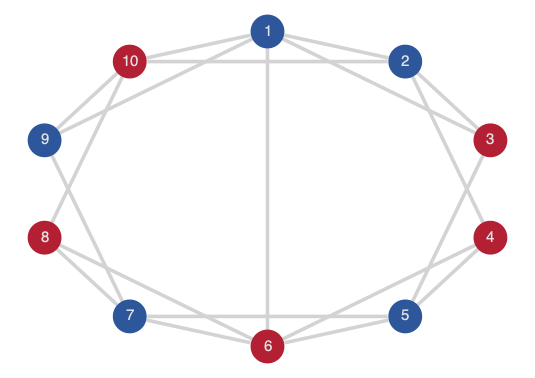

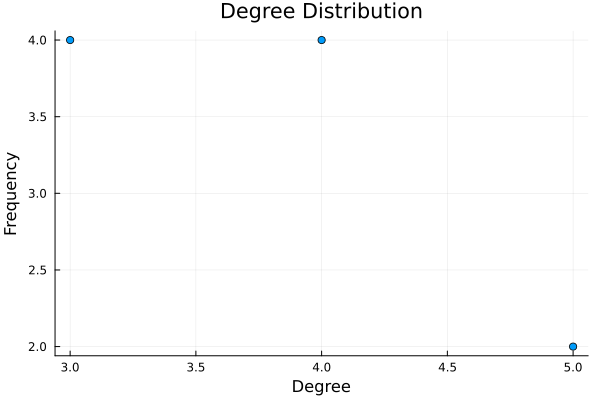

In [6]:
@testset "create_weighted_cycle_graph" begin
    mat = create_weighted_cycle_graph(10, 4, 0.5)
    @test mat_nv(mat) == 10
    @test mat_ne(mat) == 20
    @test mat_degree(mat) == fill(4, 10)
    
    mat_update_weight!(mat, 1, 6, 0.1)
    @test mat_nv(mat) == 10
    @test mat_ne(mat) == 21
    @test mat_degree(mat) == [5, 4, 4, 4, 4, 5, 4, 4, 4, 4]

    mat_update_weight!(mat, 3, 4, 0.0)
    mat_update_weight!(mat, 8, 9, 0.0)
    @test mat_nv(mat) == 10
    @test mat_ne(mat) == 19
    @test mat_degree(mat) == [5, 4, 3, 3, 4, 5, 4, 3, 3, 4]
    
    plot_graph(mat, rand([DARK_RED, DARK_BLUE], 10))
end

N = 10
g = create_cycle_graph(N, 4)
add_edge!(g, 1, 6)
rem_edge!(g, 3, 4)
rem_edge!(g, 8, 9)
desc(g)

plot_graph(g, rand([DARK_RED, DARK_BLUE], 10))
plot_degree_distribution(g)

## AR(1)

In [8]:
function moving_average(data::Vector{Float64}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end;

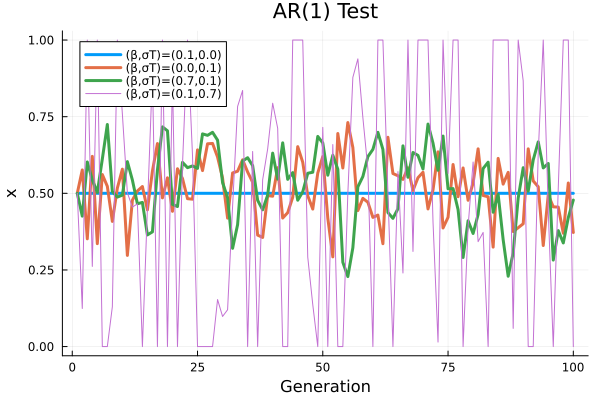

In [9]:
μ = 0.5
t_max = 100

plot(xlabel="Generation", ylabel="x", title="AR(1) Test")
β, σ = (0.1, 0.0)
plot!(ar1(μ, β, σ, t_max), label="(β,σT)=($(β),$(σ))", lw=3)
β, σ = (0.0, 0.1)
plot!(ar1(μ, β, σ, t_max), label="(β,σT)=($(β),$(σ))", lw=3)
β, σ = (0.7, 0.1)
plot!(ar1(μ, β, σ, t_max), label="(β,σT)=($(β),$(σ))", lw=3)
β, σ = (0.1, 0.7)
plot!(ar1(μ, β, σ, t_max), label="(β,σT)=($(β),$(σ))", lw=1)
# plot!(ar1(μ, β, σ, t_max), label="(β,σ)=($(β),$(σ))")
# β, σ = (0.1, 0.4)
# σ, β = (0.5, 0.5)
# plot!(ar1(μ, σ, β, t_max), label="(σ,β)=($(σ),$(β))", xlabel="Generation", ylabel="x", title="AR(1) Test")

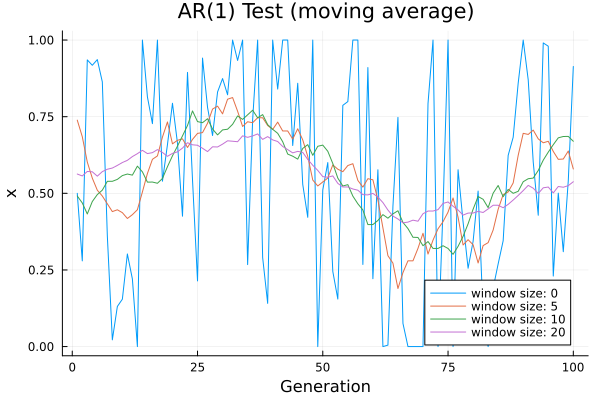

In [10]:
plot(xlabel="Generation", ylabel="x", title="AR(1) Test (moving average)")
β, σ = (0.4, 0.4)
data = ar1(μ, β, σ, t_max)
plot!(moving_average(data, 0), label="window size: 0")
plot!(moving_average(data, 5), label="window size: 5")
plot!(moving_average(data, 10), label="window size: 10")
plot!(moving_average(data, 20), label="window size: 20")

## Model structure

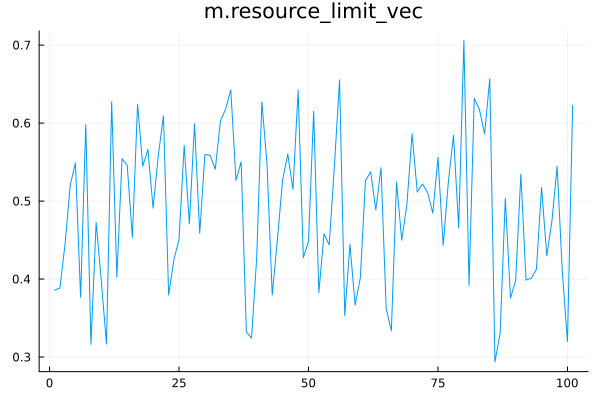

Test Summary: | Pass  Total  Time
Param & Model |   13     13  0.2s


In [12]:
@enum Strategy C D

# strategies_to_colors(strategy_vec::Vector{Strategy})::Vector{RGB} = [s == C ? DARK_BLUE : DARK_RED for s in strategy_vec]

mutate(strategy::Strategy)::Strategy = (strategy == C ? D : C)

@with_kw struct Param
    # Spatial Structure
    N::Int = 100       # population
    k₀::Int = 4        # initial degree
    w₀::Float64 = 1.0  # initial weight

    # Interaction
    C_rate₀::Float64 = 0.5     # initial cooperator(C)'s freqtrialscy
    b::Float64 = 1.25          # benefit to defect
    relationship_increment_factor::Float64 = 1.1

    # Environmental Variability
    peak_node_resource::Float64  = 1.0
    resource_decrement_factor::Float64 = 0.02
    peak_node_variability::Int = 1   # Movable range of prime node (EVMode: PEAK_NODE, BOTH)
    resource_limit_μ::Float64 = 0.5  # expected value of resource limit
    resource_limit_β::Float64 = 0.1  # Autoregressive coefficient of resource limit
    resource_limit_σ::Float64 = 0.1  # SD of white noise of resource limit

    # Imitation
    δ::Float64 = 0.99  # selection pressure
    μ::Float64 = 0.01  # mutation rate

    # Misc
    generations::Int = 2_000  # time steps
    trials::Int = 10          # trial count
end

function to_string(p::Param)::String
    fields = [getfield(p, f) for f in fieldnames(Param)]
    return join(fields, ",")
end

mutable struct Model
    # model's parameters
    p::Param
    t::Int          # time step
    peak_node::Int  # node which has the greatest resource
    resource_limit_vec::Vector{Float64}

    # agent's parameters
    strategy_vec::Vector{Strategy}  # agents' strategy
    resource_vec::Vector{Float64}   # agents' resource
    relation_mat::Matrix{Float64}

    function Model(p::Param, rng::MersenneTwister)
        resource_limit_vec = ar1(p.resource_limit_μ, p.resource_limit_β, p.resource_limit_σ, p.generations, rng)

        C_count = round(Int, p.N * p.C_rate₀)
        strategy_vec = shuffle(rng, [fill(C, C_count); fill(D, p.N - C_count)])

        resource_vec = fill(0.0, p.N)

        relation_mat = create_weighted_cycle_graph(p.N, p.k₀, p.w₀)

        return new(p, 1, 1, resource_limit_vec, strategy_vec, resource_vec, relation_mat)
    end
end

C_rate(m::Model)::Float64 = mean(m.strategy_vec .== C)

average_resource(m::Model)::Float64 = mean(m.resource_vec)

@testset "Param & Model" begin
    rng = MersenneTwister(1)
    m = Model(Param(), rng)
    @test m.p.N == mat_nv(m.relation_mat) == length(m.strategy_vec) == length(m.resource_vec) == 100
    @test C_rate(m) == 0.5
    @test m.resource_vec == fill(0.0, m.p.N)
    @test mean(mat_degree(m.relation_mat)) == 4.0
    @test m.t == 1
    @test m.peak_node == 1

    m = Model(Param(N = 10, k₀ = 6, C_rate₀ = 0.2), rng)
    @test m.p.N == mat_nv(m.relation_mat) == length(m.strategy_vec) == length(m.resource_vec) == 10
    @test C_rate(m) == mean(m.strategy_vec .== C) == 0.2
    @test m.resource_vec == fill(0.0, m.p.N)
    @test mean(mat_degree(m.relation_mat)) == 6.0

    # resource_limit_vec
    @test mean(m.resource_limit_vec) ≈ 0.5 atol = 0.01
    @test std(m.resource_limit_vec) ≈ 0.1 atol = 0.01
    plot(m.resource_limit_vec[1000:1100], legend=false, title="m.resource_limit_vec") |> display

    @test to_string(Param()) == "100,4,1.0,0.5,1.25,1.1,1.0,0.02,1,0.5,0.1,0.1,0.99,0.01,2000,10"
end;

## Resource allocation

In [14]:
function resource_allocation!(m::Model, rng::MersenneTwister)::Nothing
    if m.p.peak_node_variability < 0
        m.peak_node = rand(rng, 1:m.p.N)
    elseif m.p.peak_node_variability == 0
        # peak_node is not moved
    else
        m.peak_node = mod(m.peak_node + rand(rng, -m.p.peak_node_variability:m.p.peak_node_variability) - 1, m.p.N) + 1
        # m.peak_node += m.p.peak_node_variability
        # m.peak_node = m.peak_node > 100 ? m.peak_node - 100 : m.peak_node
    end
    
    distance_vec = [abs(i - m.peak_node) for i in 1:m.p.N]
    distance_vec = [distance > m.p.N ÷ 2 ? m.p.N - distance : distance for distance in distance_vec]
    m.resource_vec = [m.p.peak_node_resource - (m.p.resource_decrement_factor * distance) for distance in distance_vec]
    m.resource_vec = [max(r, 0) for r in m.resource_vec]

    return
end

@testset "resource_allocation!" begin
    @testset "peak_node_variability = -1" begin
        m = Model(Param(N = 10, k₀ = 4, peak_node_variability = -1, resource_decrement_factor = 0.3), MersenneTwister(1))
        resource_allocation!(m, MersenneTwister(1))
        @test m.peak_node == 7
        @test m.resource_vec ≈ [0.0, 0.0, 0.0, 0.1, 0.4, 0.7, 1.0, 0.7, 0.4, 0.1]

        m = Model(Param(N = 10, k₀ = 4, peak_node_variability = -1, resource_decrement_factor = 0.25), MersenneTwister(1))
        resource_allocation!(m, MersenneTwister(2))
        @test m.peak_node == 1
        @test m.resource_vec == [1.0, 0.75, 0.5, 0.25, 0.0, 0.0, 0.0, 0.25, 0.5, 0.75]
    end

    @testset "peak_node_variability = 0" begin
        m = Model(Param(N = 10, k₀ = 4, resource_decrement_factor = 0.1, peak_node_variability  = 0), MersenneTwister())
        resource_allocation!(m, MersenneTwister())
        @test m.peak_node == 1
        @test m.resource_vec ≈ [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.6, 0.7, 0.8, 0.9]

        m = Model(Param(N = 10, k₀ = 4, resource_decrement_factor = 0.3, peak_node_variability  = 0), MersenneTwister())
        resource_allocation!(m, MersenneTwister())
        @test m.peak_node == 1
        @test m.resource_vec ≈ [1.0, 0.7, 0.4, 0.1, 0.0, 0.0, 0.0, 0.1, 0.4, 0.7]

        m = Model(Param(N = 10, k₀ = 4, resource_decrement_factor = 0.5, peak_node_variability  = 0), MersenneTwister())
        resource_allocation!(m, MersenneTwister())
        @test m.peak_node == 1
        @test m.resource_vec ≈ [1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
    end

    @testset "peak_node_variability = 1" begin
        m = Model(Param(N = 10, k₀ = 4, peak_node_variability  = 1), MersenneTwister())
        prior_position = m.peak_node
        hop_vec = []
        for _ in 1:100
            resource_allocation!(m, MersenneTwister())
            hop = prior_position - m.peak_node
            hop = hop > 1 ? -1 : hop
            hop = hop < -1 ? 1 : hop
            append!(hop_vec, hop)
            prior_position = m.peak_node
        end
        @test mean(hop_vec) ≈ 0.0 atol = 0.2
        @test std(hop_vec) ≈ 0.8 atol = 0.1
    end
end;

Test Summary:        | Pass  Total  Time
resource_allocation! |   12     12  0.1s


## Interaction

In [16]:
function contributable_resource(resource::Float64, resource_limit::Float64)::Float64
    # 全リソースを拠出するパターン
    # return resource
    # 余剰リソースを拠出するパターン
    return max(resource - resource_limit, 0)
    # リソースリミットを超えている場合は余剰リソースを拠出し、リソースリミットを下回っている場合は全リソースを拠出するパターン
    # return resource - (resource > resource_limit ? resource_limit : 0)
end

function weighted_interaction!(m::Model, rng::MersenneTwister)::Vector{Tuple{Int, Int}}
    id_pair_vec = Vector{Tuple{Int, Int}}()

    for focal_id in shuffle(rng, 1:m.p.N)
        # focal と他のエージェントとの関係ベクトル
        relation_vec = m.relation_mat[focal_id, :]
        sum(relation_vec) == 0 && continue

        # opponent を選択 (関係が深いエージェントが選ばれやすい)
        opponent_id = sample(rng, 1:m.p.N, Weights(relation_vec))
        # opponent_id = rand(rng, filter(!=(focal_id), 1:m.p.N))
        push!(id_pair_vec, (focal_id, opponent_id))

        # focal と opponent が拠出可能なリソース
        focal_resource, opponent_resource = [contributable_resource(r, m.resource_limit_vec[m.t]) for r in m.resource_vec[[focal_id, opponent_id]]]

        # Pair-wise PGG
        strategy_pair = m.strategy_vec[[focal_id, opponent_id]]
        if strategy_pair == [C, C]
            poor_resource = (focal_resource + opponent_resource) * m.p.b
            m.resource_vec[focal_id] += poor_resource / 2 - focal_resource
            m.resource_vec[opponent_id] += poor_resource / 2 - opponent_resource
        elseif strategy_pair == [C, D]
            poor_resource = focal_resource * m.p.b
            m.resource_vec[focal_id] += poor_resource / 2 - focal_resource
            m.resource_vec[opponent_id] += poor_resource / 2
        elseif strategy_pair == [D, C]
            poor_resource = opponent_resource * m.p.b
            m.resource_vec[focal_id] += poor_resource / 2
            m.resource_vec[opponent_id] += poor_resource / 2 - opponent_resource
        end

        # Update relationship
        if strategy_pair == [C, C]
            m.relation_mat[focal_id, opponent_id] *= m.p.relationship_increment_factor
        else
            m.relation_mat[focal_id, opponent_id] /= m.p.relationship_increment_factor
        end
        m.relation_mat[focal_id, opponent_id] = max(m.relation_mat[focal_id, opponent_id], 1.0)
        m.relation_mat[opponent_id, focal_id] = m.relation_mat[focal_id, opponent_id]
    end

    return id_pair_vec
end

@testset "contributable_resource" begin
    @test contributable_resource(10.0, 0.5) == 9.5
    @test contributable_resource(1.0, 0.5) == 0.5
    @test contributable_resource(0.51, 0.5) ≈ 0.01
    @test contributable_resource(0.5, 0.5) == 0.0
    @test contributable_resource(0.49, 0.5) == 0.0
    @test contributable_resource(0.0, 0.5) == 0.0
    @test contributable_resource(-10.0, 0.5) == 0.0
end

@testset "weighted_interaction!" begin
    @testset "normal" begin
        p = Param(N = 10, k₀ = 4, C_rate₀ = 0.4, resource_decrement_factor = 0.2, resource_limit_μ = 0.5)
        m = Model(p, MersenneTwister(1))
        resource_allocation!(m, MersenneTwister(1))
        @test m.strategy_vec == [D, D, D, D, D, C, C, C, D, C]
        @test m.resource_vec ≈ [1.0, 0.8, 0.6, 0.4, 0.2, 0.0, 0.2, 0.4, 0.6, 0.8]

        id_pair_vec = weighted_interaction!(m, MersenneTwister(1))
        @test id_pair_vec == [(9, 7), (5, 7), (1, 3), (7, 5), (4, 3), (10, 1), (6, 5), (2, 10), (8, 6), (3, 4)]
        @test m.resource_vec ≈ [1.1875, 0.9171875, 0.6, 0.4, 0.2, 0.0, 0.2, 0.4, 0.6, 0.6171875]

        p = Param(N = 10, k₀ = 4, C_rate₀ = 0.4, resource_decrement_factor = 0.2, resource_limit_μ = 0.0)
        m = Model(p, MersenneTwister(1))
        resource_allocation!(m, MersenneTwister(1))

        id_pair_vec = weighted_interaction!(m, MersenneTwister(1))
        @test id_pair_vec == [(9, 7), (5, 7), (1, 3), (7, 5), (4, 3), (10, 1), (6, 5), (2, 10), (8, 6), (3, 4)]
        @test m.resource_vec ≈ [1.5, 1.1125, 0.6, 0.4, 0.326953125, 0.25, 0.048828125, 0.25, 0.725, 0.3125]
    end
    
    @testset "solitary node" begin
        p = Param(N = 10, k₀ = 4, C_rate₀ = 0.4, resource_decrement_factor = 0.2, resource_limit_μ = 0.0)
        m = Model(p, MersenneTwister(1))
        resource_allocation!(m, MersenneTwister(1))

        # delete all edges of 3
        mat_update_weight!(m.relation_mat, 3, 1, 0.0)
        mat_update_weight!(m.relation_mat, 3, 2, 0.0)
        mat_update_weight!(m.relation_mat, 3, 4, 0.0)
        mat_update_weight!(m.relation_mat, 3, 5, 0.0)
        # delete all edges of 6 except (6, 4)
        mat_update_weight!(m.relation_mat, 6, 5, 0.0)
        mat_update_weight!(m.relation_mat, 6, 7, 0.0)
        mat_update_weight!(m.relation_mat, 6, 8, 0.0)
        # delete all edges of 10
        mat_update_weight!(m.relation_mat, 10, 1, 0.0)
        mat_update_weight!(m.relation_mat, 10, 2, 0.0)
        mat_update_weight!(m.relation_mat, 10, 8, 0.0)
        mat_update_weight!(m.relation_mat, 10, 9, 0.0)

        id_pair_vec = weighted_interaction!(m, MersenneTwister(1))
        @test id_pair_vec == [(9, 7), (5, 7), (1, 2), (7, 5), (4, 2), (6, 4), (2, 1), (8, 9)]
        @test m.resource_vec ≈ [1.0, 0.8, 0.6, 0.4, 0.326953125, 0.0, 0.048828125, 0.25, 0.975, 0.8]
    end
end;

Test Summary:          | Pass  Total  Time
contributable_resource |    7      7  0.0s
Test Summary:         | Pass  Total  Time
weighted_interaction! |    8      8  0.1s


## Death & Birth

In [18]:
function regularize_resource_vec(resource_vec::Vector{Float64}, positive::Bool)::Weights
    weights = positive ? resource_vec .- minimum(resource_vec) : maximum(resource_vec) .- resource_vec
    weights .+= 0.0001
    weights ./= maximum(weights)

    return Weights(weights)
end

function get_death_parent_id_vec(m::Model, rng::MersenneTwister)::Tuple{Vector{Int}, Vector{Int}}
    death_id_vec = findall(<(m.resource_limit_vec[m.t]), m.resource_vec)
    death_count = length(death_id_vec)
    parent_id_vec = Int[]

    if death_count > 0
        parent_weights = regularize_resource_vec(m.resource_vec, true)
        parent_id_vec = sample(rng, 1:m.p.N, parent_weights, death_count, replace = false)
    end

    return shuffle(rng, death_id_vec), shuffle(rng, parent_id_vec)
end

function weighted_death_birth!(m::Model, rng::MersenneTwister)::Tuple{Vector{Int}, Vector{Int}}
    death_id_vec, parent_id_vec = get_death_parent_id_vec(m, rng)
    death_count = length(death_id_vec)
    if death_count == 0
        return death_id_vec, parent_id_vec
    end

    # Strategy
    parent_strategy_vec = m.strategy_vec[parent_id_vec]
    parent_strategy_vec = [rand(rng) > m.p.μ ? s : mutate(s) for s in parent_strategy_vec]
    m.strategy_vec[death_id_vec] .= parent_strategy_vec

    # Graph
    ## Delete edges
    m.relation_mat[death_id_vec, :] .= 0.0
    m.relation_mat[:, death_id_vec] .= 0.0

    ## Add edges
    add_count = Int(m.p.N * m.p.k₀ / 2 - mat_ne(m.relation_mat))

    ### initialize non_neighbors_dict and candidate_id_dict
    all_nodes = collect(1:m.p.N)
    parent_id_set = Set(parent_id_vec)
    non_neighbors_dict = Dict{Int, Vector{Int}}()
    candidates_dict = Dict{Int, Vector{Int}}()
    for death_id in death_id_vec
        non_neighbors_dict[death_id] = filter(!=(death_id), all_nodes)
        candidates_dict[death_id] = filter(in(parent_id_set), non_neighbors_dict[death_id])
    end

    while add_count > 0
        for death_id in death_id_vec
            # parent_id の候補から parent_id をランダムに選択
            if isempty(candidates_dict[death_id])
                candidates_dict[death_id] = non_neighbors_dict[death_id]
            end
            parent_id = rand(rng, candidates_dict[death_id])

            # update relationship graph
            mat_update_weight!(m.relation_mat, parent_id, death_id, m.p.w₀)

            # update non_neighbors_dict and candidates_dict
            non_neighbors_dict[death_id] = filter(!=(parent_id), non_neighbors_dict[death_id])
            candidates_dict[death_id] = filter(!=(parent_id), candidates_dict[death_id])
            if parent_id in death_id_vec
                non_neighbors_dict[parent_id] = filter(!=(death_id), non_neighbors_dict[parent_id])
                candidates_dict[parent_id] = filter(!=(death_id), candidates_dict[parent_id])
            end

            add_count -= 1
            add_count == 0 && break
        end
    end

    @assert m.p.N * m.p.k₀ / 2 == mat_ne(m.relation_mat) "$(m.p.N * m.p.k₀ / 2) == $(mat_ne(m.relation_mat))"

    return death_id_vec, parent_id_vec
end

@testset "regularize_resource_vec" begin
    @test regularize_resource_vec([0.0, 0.0, 0.0, 0.0, 0.0], true) == [1.0, 1.0, 1.0, 1.0, 1.0]
    @test regularize_resource_vec([1.0, 1.0, 1.0, 1.0, 1.0], true) == [1.0, 1.0, 1.0, 1.0, 1.0]

    @test regularize_resource_vec([0.0, 0.0, 1.0, 0.0, 0.0], true) ≈ [0.0, 0.0, 1.0, 0.0, 0.0] atol = 0.001
    @test regularize_resource_vec([0.0, 0.0, 1.0, 0.0, 0.0], false) ≈ [1.0, 1.0, 0.0, 1.0, 1.0] atol = 0.001
    @test regularize_resource_vec([0.0, 0.0, -1.0, 0.0, 0.0], true) ≈ [1.0, 1.0, 0.0, 1.0, 1.0] atol = 0.001

    @test regularize_resource_vec([0.0, 0.2, 0.4, 0.6, 0.8], true) ≈ [0.0, 0.25, 0.5, 0.75, 1.0] atol = 0.001
    @test regularize_resource_vec([0.0, 0.2, 0.4, 0.6, 0.8], false) ≈ [1.0, 0.75, 0.5, 0.25, 0.0] atol = 0.001
    @test regularize_resource_vec([0.0, -0.2, -0.4, -0.6, -0.8], true) ≈ [1.0, 0.75, 0.5, 0.25, 0.0] atol = 0.001
end

@testset "weighted_death_birth!" begin
    p = Param(N = 10, k₀ = 4, C_rate₀ = 0.4, resource_limit_μ = 0.5, resource_decrement_factor = 0.2)
    m = Model(p, MersenneTwister(1))
    m.strategy_vec = [D, D, C, D, C, D, D, C, D, C]
    resource_allocation!(m, MersenneTwister(1))
    @test m.peak_node == 1
    @test mat_degree(m.relation_mat) == fill(4, 10)

    death_id_vec, parent_id_vec = weighted_death_birth!(m, MersenneTwister(1))
    @test death_id_vec == [5, 7, 6, 4, 8]
    @test parent_id_vec == [4, 2, 8, 3, 1]
    @test m.strategy_vec == [D, D, C, C, D, C, D, D, D, C]
    @test mat_degree(m.relation_mat) == [7, 5, 6, 3, 3, 3, 3, 5, 2, 3]
    @test mean(mat_degree(m.relation_mat)) == 4
    @test mat_ne(m.relation_mat) == 20
end;

Test Summary:           | Pass  Total  Time
regularize_resource_vec |    8      8  0.1s
Test Summary:         | Pass  Total  Time
weighted_death_birth! |    8      8  0.3s


## Run all

In [20]:
function run_trials!(p::Param)::Matrix{Float64}
    C_rate_mat = fill(0.0, p.trials, p.generations)
    
    for trial in 1:p.trials
        seed = round(Int, time() * 1_000_000) # 現在時刻(マイクロ秒単位)を乱数シードとして使用
        rng = MersenneTwister(seed)
        m = Model(p, rng)

        for generation in 1:p.generations
            m.t = generation
            resource_allocation!(m, rng)
            weighted_interaction!(m, rng)
            weighted_death_birth!(m, rng)

            C_rate_mat[trial, generation] = C_rate(m)
        end
    end

    return C_rate_mat
end

@testset "sanity check" begin
    p = Param(generations = 1_000, trials = 3)
    m = Model(p, MersenneTwister())
    # run!(m, MersenneTwister())
    run_trials!(p)
end;

# # Set, Vec (filter) (initialize non_neighbors_dict and candidate_id_dict を外出し) 8.3s, 8.5s, 8.3s
# # non_neighbors_dict and candidate_id_dict の中身を Set にしてもパフォーマンスは改善しない。
# # simd も効果ない。
# # Set, Vec (filter) 10.3s, 9.9s, 10.1s
# # Set, Vec (内包表現) 12.9s, 13.5s
# # Vec, Vec 18.5s
# # Set, Set 36.9s
# @testset "Performance check" begin
#     p = Param(generations = 10_000, trials = 10)
#     m = Model(p, MersenneTwister())
#     run_trials!(p)
# end

# # Performance Profiling
# Profile.clear()
# p = Param(generations = 10_000, trials = 10)
# @profview run_trials!(p);

Test Summary: |Time
sanity check  | None  0.3s


# Results

## 概要

In [23]:
resource_decrement_factor = 0.02
resource_limit_μ = 0.5
C_rate₀_vec = [0.0]
relationship_increment_factor_vec = [1.0, 1.1, 1.2]
b_vec = 1.0:0.1:2.0

# 1. (peak_node, resource_limit) = (変動, 固定), (固定, 固定)
resource_limit_β_vec = [0.0]
resource_limit_σ_vec = [0.0]
peak_node_variability_vec = 0:49

params1 = vec([(C_rate₀, relationship_increment_factor, b, resource_limit_β, resource_limit_σ, peak_node_variability)
    for C_rate₀ in C_rate₀_vec,
        relationship_increment_factor in relationship_increment_factor_vec,
        b in b_vec,
        resource_limit_β in resource_limit_β_vec,
        resource_limit_σ in resource_limit_σ_vec,
        peak_node_variability in peak_node_variability_vec])

# 2. (peak_node, resource_limit) = (固定, 変動)
resource_limit_β_vec = 0.0:0.1:0.9
resource_limit_σ_vec = [0.01, 0.1, 0.2, 0.3]
peak_node_variability_vec = [0]

params2 = vec([(C_rate₀, relationship_increment_factor, b, resource_limit_β, resource_limit_σ, peak_node_variability)
    for C_rate₀ in C_rate₀_vec,
        relationship_increment_factor in relationship_increment_factor_vec,
        b in b_vec,
        resource_limit_β in resource_limit_β_vec,
        resource_limit_σ in resource_limit_σ_vec,
        peak_node_variability in peak_node_variability_vec])

# 3. (peak_node, resource_limit) = (変動, 変動)
b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]
peak_node_variability_vec = [1, 2, 4, 8, 16]

params3 = vec([(C_rate₀, relationship_increment_factor, b, resource_limit_β, resource_limit_σ, peak_node_variability)
    for C_rate₀ in C_rate₀_vec,
        relationship_increment_factor in relationship_increment_factor_vec,
        b in b_vec,
        resource_limit_β in resource_limit_β_vec,
        resource_limit_σ in resource_limit_σ_vec,
        peak_node_variability in peak_node_variability_vec])

params = shuffle([params1; params2; params3])
# params = shuffle(params1)
# params = shuffle(params2)
# params = shuffle(params3)

@show length(params), length(Set(params))
@test Set([param[1] for param in params]) == Set(C_rate₀_vec)
@test Set([param[2] for param in params]) == Set(relationship_increment_factor_vec)
@show sort(unique([param[3] for param in params]))
@show sort(unique([param[4] for param in params]))
@show sort(unique([param[5] for param in params]))
@show sort(unique([param[6] for param in params]));

(length(params), length(Set(params))) = (3720, 3720)
sort(unique([param[3] for param = params])) = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
sort(unique([param[4] for param = params])) = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sort(unique([param[5] for param = params])) = [0.0, 0.01, 0.1, 0.2, 0.3]
sort(unique([param[6] for param = params])) = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [24]:
const FILE_NAME = "../output/CircleModel_$(Dates.format(now(), "yyyymmdd_HHMMSS")).csv"
const FIELD_NAMES = join(fieldnames(Param), ",") * ",cooperation_rate"
@show FILE_NAME
@show FIELD_NAMES;

FILE_NAME = "../output/CircleModel_20240829_210419.csv"
FIELD_NAMES = "N,k₀,w₀,C_rate₀,b,relationship_increment_factor,peak_node_resource,resource_decrement_factor,peak_node_variability,resource_limit_μ,resource_limit_β,resource_limit_σ,δ,μ,generations,trials,cooperation_rate"


In [25]:
write(FILE_NAME, "$(FIELD_NAMES)\n")
lk = Threads.ReentrantLock()

Threads.@threads for (C_rate₀, relationship_increment_factor, b, resource_limit_β, resource_limit_σ, peak_node_variability) in params
    p = Param(
        N = 100, k₀ = 4, generations = 10_000, trials = 10,
        resource_decrement_factor = resource_decrement_factor,
        C_rate₀ = C_rate₀,
        relationship_increment_factor = relationship_increment_factor,
        b = b,
        resource_limit_μ = resource_limit_μ,
        resource_limit_β = resource_limit_β,
        resource_limit_σ = resource_limit_σ,
        peak_node_variability = peak_node_variability,
    )
    C_rate_mat = run_trials!(p)
    result_C_rate = mean(C_rate_mat[:, round(Int, p.generations * 0.5):p.generations])

    lock(lk) do
        open(FILE_NAME, "a") do io
            write(io, "$(to_string(p)),$(result_C_rate)\n")
            flush(io)
        end
    end
end;

## 地理的差異なし

- contributable_resource で、余剰リソースのみを拠出する場合
    - resource_limitを超えるリソースが配分される場合、誰も死なないので、集団構造に変化は起こらない。
    - resource_limitを下回るリソースが配分される場合、誰もゲームでリソースを拠出せず、リソースの変化は起こらない。毎世代全員死ぬ。その結果、協力率は50%で安定する。なぜなら、単純な突然変異過程になるので、多数派戦略は逆転しやすく、少数派戦略は維持されやすいので、多数派・少数派が均衡する50%ラインで安定するから。
- contributable_resource で、余剰リソースがあれば余剰リソースのみを、リミットを下回っている場合は全リソースを拠出する場合
    - resource_limitを超えるリソースが配分される場合、誰も死なないので、集団構造に変化は起こらない。
    - resource_limitを下回るリソースが配分される場合、協力者は全リソースを拠出する。結果的に非協力者に食い物にされるため、非協力者が生き残る。b = 2.0 を超えると、非協力者からの搾取の影響が小さくなるため、協力が進化する。

In [27]:
# C_rate₀ = 0.0
# b_vec = [1.0, 1.25, 1.5, 1.75, 2.0]
# relationship_increment_factor = 1.0
# resource_decrement_factor = 0.0
# resource_limit_μ = 0.5
# resource_limit_β_vec = [0.0, 0.1, 0.4, 0.8]
# resource_limit_σ = 0.1
# peak_node_resource = 0.5
# peak_node_variability = 0
# random_seed = 1

# params = vec([(b, resource_limit_β) for b in b_vec, resource_limit_β in resource_limit_β_vec]);

In [28]:
# for (b, resource_limit_β) in params
#     p = Param(
#         N = 100, k₀ = 4, generations = 10_000,
#         b = b,
#         C_rate₀ = C_rate₀,
#         peak_node_variability = peak_node_variability,
#         relationship_increment_factor = relationship_increment_factor,
#         resource_decrement_factor = resource_decrement_factor,
#         resource_limit_μ = resource_limit_μ,
#         resource_limit_β = resource_limit_β,
#         resource_limit_σ = resource_limit_σ,
#         peak_node_resource = peak_node_resource
#     )
#     m = Model(p, MersenneTwister(random_seed))
#     C_rate_vec, average_resource_vec, death_count_vec, peak_node_vec, strategy_mat, degree_mat, average_distance_vec, clustering_coefficient_vec = run!(m, MersenneTwister(random_seed))
    
#     println("b: $(b), resource_limit_β: $(resource_limit_β)")
#     println("C_rate: $(mean(C_rate_vec[round(Int, end * 0.5):end]))")
#     println("average_resource: $(mean(average_resource_vec[round(Int, end * 0.5):end]))")
#     g = SimpleGraph(m.relation_mat)
#     desc(g)
#     plot_graph(m.relation_mat, strategies_to_colors(m.strategy_vec))
#     plot_degree_distribution(g)
    
#     xticks = collect(0:1000:m.p.generations)
#     xticks[1] = 1

#     p = plot(C_rate_vec, xticks=xticks, label=false, color=:blue)
#     plot!(twinx(), average_resource_vec, label=false, color=:red)
#     display(p)
#     heatmap(transpose(strategy_mat .== C), color=[:red, :blue], xlabel="Generation", xticks=xticks, ylabel="Node", title="Strategy transition") |> display

#     p1 = plot(death_count_vec, xticks=xticks, title="Death count transition")
#     p2 = plot(peak_node_vec, xticks=xticks, title="Prime node transition")
#     plot(p1, p2, layout=(1, 2), size=(1000, 400)) |> display

#     plot(moving_average(m.resource_limit_vec), xticks=xticks, title="Resource limit transition") |> display

#     # Degree
#     degree_distribution_vec = [countmap(degree_mat[gen, :]) for gen in 1:m.p.generations]
#     heatmap_data = zeros(Int, 11, m.p.generations)
#     for gen in 1:m.p.generations
#         for (degree, count) in degree_distribution_vec[gen]
#             if degree > 10
#                 heatmap_data[11, gen] += count
#             else
#                 heatmap_data[degree + 1, gen] = count
#             end
#         end
#     end
#     yticks = string.(collect(0:10))
#     yticks[11] = "≧10"
#     heatmap(heatmap_data, xlabel="Generation", ylabel="Degree", xticks=xticks, yticks=(1:length(yticks), yticks), title="Degree Distribution", color=:viridis) |> display
    
#     p3 = heatmap(transpose(degree_mat), xlabel="Generation", ylabel="Node", xticks=xticks, title="Degree Distribution transition")
#     p4 = plot(title="Degree transition", xticks=xticks)
#     plot!(std(degree_mat, dims=2), color=:blue, label="SD")
#     # plot!(twinx(), maximum(degree_mat, dims=2), color=:red, label="Max")
#     plot(p3, p4, layout=(1, 2), size=(1000, 400)) |> display

#     # L and C
#     plot(
#         plot(average_distance_vec, xticks=xticks, title="Average distance (L) transition"),
#         plot(clustering_coefficient_vec, xticks=xticks, title="Clustering coefficient (C) transition"),
#         layout=(1, 2),
#         size=(1000, 400)
#     ) |> display
# end;